In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# reset plt style
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
# set home path
folder = 'C:\\Users\joche\FIM Kernkompetenzzentrum\Paper Agent-based Modeling - Dokumente\General\\01 Data\pv_generation'
os.chdir(folder)

In [2]:
# read in dataframe, index with datetime and rename cols
df = pd.read_csv('PVGIS_Timeseries_48.776_11.381_SA2_1kWp_crystSi_14_35deg_0deg_2019_2020.csv', header=8).iloc[:-9,:]
df['time'] = pd.Series(pd.date_range(start='2019-01-01', end='2020-12-31 23:00', freq='H'))
df.rename(columns={'P': 'Power[W]', 'T2m': 'temperature[Celsius]'}, inplace=True)
df['Power[W]'] = df['Power[W]'].astype(float)
# separate in 2019 and 2020 data
df_2019 = df[df['time'] < '2020-01-01']
df_2020 = df[df['time'] >= '2020-01-01']
df

,time,Power[W],Gb(i),Gd(i),Gr(i),H_sun,temperature[Celsius],WS10m,Int
0,2019-01-01 00:00:00,0.0,0.0,0.0,0.0,0.0,4.15,1.93,0.0
1,2019-01-01 01:00:00,0.0,0.0,0.0,0.0,0.0,4.05,2.07,0.0
2,2019-01-01 02:00:00,0.0,0.0,0.0,0.0,0.0,4.06,2.21,0.0
3,2019-01-01 03:00:00,0.0,0.0,0.0,0.0,0.0,4.04,2.41,0.0
4,2019-01-01 04:00:00,0.0,0.0,0.0,0.0,0.0,4.04,2.55,0.0
...,...,...,...,...,...,...,...,...,...
17539,2020-12-31 19:00:00,0.0,0.0,0.0,0.0,0.0,-1.13,1.31,0.0
17540,2020-12-31 20:00:00,0.0,0.0,0.0,0.0,0.0,-0.19,0.97,0.0
17541,2020-12-31 21:00:00,0.0,0.0,0.0,0.0,0.0,-0.44,0.97,0.0
17542,2020-12-31 22:00:00,0.0,0.0,0.0,0.0,0.0,0.27,0.69,0.0


In [3]:
# read in alternative data from renewables.ninja
df_ninja = pd.read_csv('renewables_ninja_pv_48.7756_11.3814_corrected.csv', header=3)
df_ninja['time'] = pd.to_datetime(df_ninja['time'], format='%Y-%m-%d %H:%M')
df_ninja['electricity'] = df_ninja['electricity'] * 1000
df_ninja.drop('local_time', axis=1, inplace=True)
df_ninja.rename(columns={'electricity' : 'Power[W]', 'temperature' : 'temperature[Celsius]'}, inplace=True)
df_ninja

,time,Power[W],irradiance_direct,irradiance_diffuse,temperature[Celsius],missing
0,2015-01-01 00:00:00,0.0,0.0,0.0,-4.755,0
1,2015-01-01 01:00:00,0.0,0.0,0.0,-4.923,0
2,2015-01-01 02:00:00,0.0,0.0,0.0,-4.983,0
3,2015-01-01 03:00:00,0.0,0.0,0.0,-4.990,0
4,2015-01-01 04:00:00,0.0,0.0,0.0,-4.917,0
...,...,...,...,...,...,...
8755,2015-12-31 19:00:00,0.0,0.0,0.0,1.035,0
8756,2015-12-31 20:00:00,0.0,0.0,0.0,1.484,0
8757,2015-12-31 21:00:00,0.0,0.0,0.0,2.061,0
8758,2015-12-31 22:00:00,0.0,0.0,0.0,2.417,0


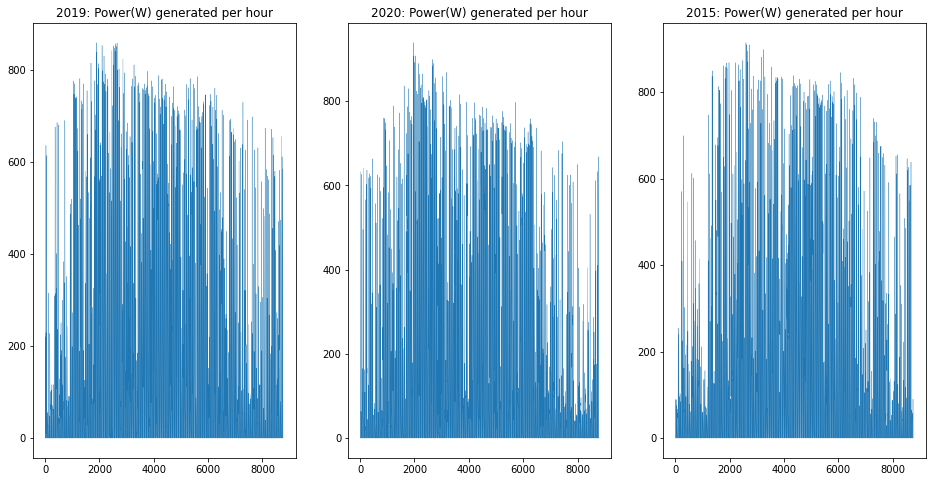

In [4]:
# plot to compare datasets
fig, ax = plt.subplots(figsize=(16,8), sharex = True, nrows = 1, ncols = 3)
ax[0].plot(df_2019['Power[W]'], linewidth = .3)
ax[0].set_title('2019: Power(W) generated per hour')
ax[1].plot(df_2020.reset_index()['Power[W]'], linewidth = .3)
ax[1].set_title('2020: Power(W) generated per hour')
ax[2].plot(df_ninja['Power[W]'], linewidth = .3)
ax[2].set_title('2015: Power(W) generated per hour')
plt.show()

Temporal disaggregation: Distribute timeseries sum percentage-wise over each hour

In [5]:
# for each row, add n empty ones
def df_add_rows(df, n):
    empty_rows = n
    df.index = range(0, empty_rows*len(df), empty_rows)
    df_out = df.reindex(index=range(empty_rows*len(df)))
    return df_out

In [6]:
def generate_time_series(start_date_str, end_date_str, interval_min):
    start_date = datetime.strptime(start_date_str, "%Y-%m-%d %H:%M")
    end_date = datetime.strptime(end_date_str, "%Y-%m-%d %H:%M")
    interval = timedelta(hours=interval_min/60)
    output = []
    while start_date <= end_date:
        output.append(start_date.strftime("%Y-%m-%d %H:%M"))
        start_date += interval
    return output

In [7]:
# create quarter hourly df_2019, interpolate missing values
df_2019_quarterh = df_add_rows(df_2019, 4)
date_index = generate_time_series(start_date_str='2019-01-01 00:00', end_date_str='2019-12-31 23:45', interval_min=15)
df_2019_quarterh['time'] = date_index
df_2019_quarterh.interpolate(axis=0, inplace=True)
df_2019_quarterh['Power[W]'] = df_2019_quarterh['Power[W]'] / 4

In [8]:
# quarter hourly factors: quarter hourly percentage of yearly generation
yearly_generated_power = sum(df_2019_quarterh['Power[W]'])
quarter_hourly_generation_factor = [i / yearly_generated_power for i in df_2019_quarterh['Power[W]']]
quarter_hourly_generation_factor = pd.DataFrame(quarter_hourly_generation_factor, columns=["qh_generation_factor"])
quarter_hourly_generation_factor

,qh_generation_factor
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
35035,0.0
35036,0.0
35037,0.0
35038,0.0


In [9]:
quarter_hourly_generation_factor.qh_generation_factor

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
35035    0.0
35036    0.0
35037    0.0
35038    0.0
35039    0.0
Name: qh_generation_factor, Length: 35040, dtype: float64

In [58]:
# write to xlsx
quarter_hourly_generation_factor.to_excel('qh_generation_factor.xlsx')

Example of use for one roof

In [10]:
# roof area [square meter]
area_roof = 35.57
# annual radiation per square meter [kWh]
annual_radiation_per_sqm_kWh = 1041.37
# annual radiation of roof [kWh]
annual_radiation_kWh = annual_radiation_per_sqm_kWh * area_roof
annual_radiation_kWh

37041.5309

In [22]:
ind = pd.date_range('2019-01-01 00:00', '2019-12-31 23:59', freq='15min')
len(ind)

35040

35040

In [28]:
quarter_hourly_generation_factor = quarter_hourly_generation_factor * 100

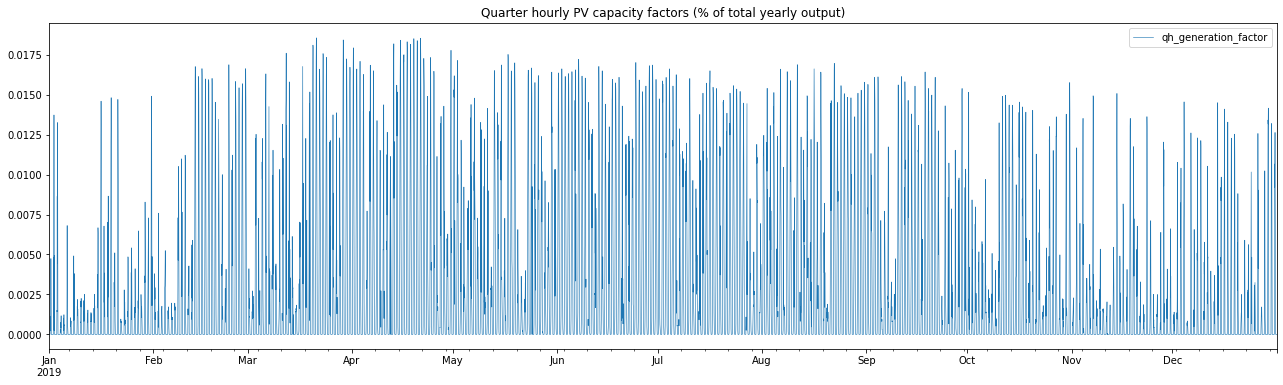

In [31]:
fig, ax = plt.subplots(figsize = (22,6))
ind = pd.date_range('2019-01-01 00:00', '2019-12-31 23:59', freq='15min')
quarter_hourly_generation_factor.index = ind
quarter_hourly_generation_factor.plot(ax = ax, linewidth = .6, title = 'Quarter hourly PV capacity factors (% of total yearly output)')
plt.show()

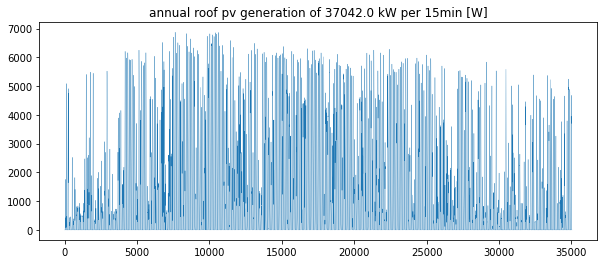

In [11]:
# distribute annual to quarter hourly generation
qh_roof_generation = pd.DataFrame([annual_radiation_kWh * 1000 * i for i in quarter_hourly_generation_factor['qh_generation_factor']], columns=['qh_generation_W'])

fig, ax = plt.subplots(figsize = (22,6))
ax.plot(qh_roof_generation.qh_generation_W, linewidth = .3)
ax.set_title(f'annual roof pv generation of {round(sum(qh_roof_generation.qh_generation_W)/1000,0)} kW per 15min [W]')
plt.show()

Example 2: using kWp/m2

In [33]:
# roof area in m2
area_roof = 35.57
# kWp per m2
kWp_per_sqm = 0.2
kWp_roof = area_roof * kWp_per_sqm
kWp_roof

7.114000000000001

In [34]:
qh_roof_generation = pd.DataFrame([annual_radiation_kWh *0.2 * i for i in model.database.qh_pv_generation_factors['qh_generation_factor']], columns=['qh_generation_kW'])

fig, ax = plt.subplots(figsize = (10,4))
ax.plot(qh_roof_generation.qh_generation_kW, linewidth = .3)
ax.set_title(f'annual roof pv generation of {round(sum(qh_roof_generation.qh_generation_kW))} kWh, 15min interval')
plt.show()

NameError: name 'quarter_hourly_generation_factor' is not defined